In [ ]:
#import sys
#print(f"Python version: {sys.version}")

# Install all required packages
#!{sys.executable} -m pip install --upgrade pip
#!{sys.executable} -m pip install numpy pandas torch torchvision gpytorch scikit-learn matplotlib tqdm pyreadr

In [55]:
# multitask_spatiotemporal_pipeline.py
import numpy as np
import pandas as pd
import torch
import gpytorch
import copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from torch.nn import Parameter
from tqdm import tqdm

# ---------------------------
# Region centroids (approximate lon, lat)
# ---------------------------
REGION_NAMES = [
    "East", "East Midlands", "London", "North East",
    "North West", "South East", "South West", "West Midlands",
    "Yorkshire And The Humber"
]

REGION_CENTROIDS = {
    "East": (-0.1, 52.2),
    "East Midlands": (-1.2, 52.9),
    "London": (-0.1, 51.5),
    "North East": (-1.6, 54.9),
    "North West": (-2.8, 54.0),
    "South East": (-0.9, 51.0),
    "South West": (-3.6, 50.8),
    "West Midlands": (-2.0, 52.5),
    "Yorkshire And The Humber": (-1.6, 53.8),
}

# ---------------------------
# Data preparation
# ---------------------------
def prepare_data_from_long_df(df,
                              region_col="region",
                              date_col="date",
                              month_col="month",
                              y1_col="excess_deaths",
                              y2_col="avg_max_temp",
                              region_names=REGION_NAMES,
                              region_centroids=REGION_CENTROIDS,
                              log_transform_deaths=True):
    """
    Converts long-form DataFrame into X, Y for GP.
    X columns: [lon, lat, time_norm, region_idx, month_idx, time_idx]
    Y columns: [log(excess_deaths+1), avg_max_temp] if log_transform_deaths=True
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    regions = list(region_names)
    dates = sorted(df[date_col].unique())
    months = sorted(df[month_col].unique())
    R = len(regions)
    T = len(dates)
    M = len(months)

    region_to_idx = {region: i for i, region in enumerate(regions)}
    month_to_idx = {month: i for i, month in enumerate(months)}

    pivot1 = df.pivot_table(index=region_col, columns=date_col, values=y1_col, aggfunc='first')
    pivot2 = df.pivot_table(index=region_col, columns=date_col, values=y2_col, aggfunc='first')
    
    pivot1 = pivot1.reindex(index=regions, columns=dates)
    pivot2 = pivot2.reindex(index=regions, columns=dates)

    if pivot1.shape != (R, T) or pivot2.shape != (R, T):
        raise ValueError(f"Expected R={R}, T={T}. Found {pivot1.shape}, {pivot2.shape}")

    excess_arr = pivot1.values.astype(np.float32)
    temp_arr = pivot2.values.astype(np.float32)
    
    if log_transform_deaths:
        excess_arr = np.log(excess_arr + 1)

    region_idx_grid = np.arange(R)
    time_idx_grid = np.arange(T)
    reg_mesh, time_mesh = np.meshgrid(region_idx_grid, time_idx_grid, indexing='ij')
    
    regs_flat = reg_mesh.ravel()
    times_flat = time_mesh.ravel().astype(np.float32)
    times_norm = times_flat / float(T - 1) if T > 1 else np.zeros_like(times_flat)
    
    month_indices = []
    for t in range(T):
        date = dates[t]
        month = pd.to_datetime(date).month
        month_indices.append(month_to_idx.get(month, 0))
    
    month_flat = np.tile(month_indices, R).astype(np.float32)
    coords = np.array([region_centroids[r] for r in regions], dtype=np.float32)
    coords_flat = coords[regs_flat]
    
    X_np = np.column_stack([
        coords_flat,
        times_norm,
        regs_flat.astype(np.float32),
        month_flat,
        times_flat
    ])
    
    Y_np = np.column_stack([excess_arr.ravel(), temp_arr.ravel()])
    X = torch.from_numpy(X_np).float()
    Y = torch.from_numpy(Y_np).float()
    
    meta = {
        "regions": regions, "dates": dates, "months": months,
        "region_to_idx": region_to_idx, "month_to_idx": month_to_idx,
        "R": R, "T": T, "M": M, "use_coords": True,
        "log_transform_deaths": log_transform_deaths
    }
    
    return X, Y, meta

def create_prediction_inputs(df_pred, time_idx, meta, region_centroids, log_transform_deaths=True):
    """Create prediction inputs for a single time point"""
    regions = meta["regions"]
    R = len(regions)
    T_full = meta["T"]
    
    time_norm = time_idx / float(T_full - 1) if T_full > 1 else 0.0
    current_date = meta["dates"][time_idx]
    current_month = pd.to_datetime(current_date).month
    month_idx = meta["month_to_idx"].get(current_month, 0)
    
    X_pred_list = []
    Y_actual_list = []
    
    for r, region in enumerate(regions):
        region_data = df_pred[df_pred['region'] == region]
        
        if len(region_data) > 0:
            coords = region_centroids[region]
            x_row = [coords[0], coords[1], time_norm, float(r), float(month_idx), float(time_idx)]
            X_pred_list.append(x_row)
            
            deaths_val = region_data['excess_deaths'].iloc[0]
            if log_transform_deaths:
                deaths_val = np.log(deaths_val + 1)
            
            y_row = [deaths_val, region_data['avg_max_temp'].iloc[0]]
            Y_actual_list.append(y_row)
        else:
            coords = region_centroids[region]
            x_row = [coords[0], coords[1], time_norm, float(r), float(month_idx), float(time_idx)]
            X_pred_list.append(x_row)
            Y_actual_list.append([np.nan, np.nan])
    
    X_pred = torch.tensor(X_pred_list, dtype=torch.float32)
    Y_actual = torch.tensor(Y_actual_list, dtype=torch.float32)
    
    return X_pred, Y_actual
    
def train_test_split_by_time(X, Y, meta, n_test=7):
    """Split by last n_test time points"""
    T = meta["T"]
    time_norm = X[:, 2].numpy()
    time_idx = np.rint(time_norm * (T - 1)).astype(int)
    test_start = T - n_test
    train_mask = time_idx < test_start
    test_mask = time_idx >= test_start
    return X[train_mask], Y[train_mask], X[test_mask], Y[test_mask]

# ---------------------------
# Multitask GP model
# ---------------------------
class SpatialTemporalMean(gpytorch.means.Mean):
    def __init__(self, num_regions, num_months, num_tasks):
        super().__init__()
        self.num_regions = num_regions
        self.num_months = num_months
        self.num_tasks = num_tasks
        self.spatial_effects = Parameter(torch.randn(num_tasks, num_regions))
        self.temporal_effects = Parameter(torch.randn(num_tasks, num_months))
        self.intercept = Parameter(torch.randn(num_tasks))

    def forward(self, x):
        batch_shape = x.shape[:-1]
        region_idx = x[..., 3].long()
        month_idx = x[..., 4].long()
        output = torch.zeros(batch_shape + (self.num_tasks,), device=x.device, dtype=x.dtype)
        
        for task in range(self.num_tasks):
            output[..., task] = (self.intercept[task] + 
                                self.spatial_effects[task, region_idx] + 
                                self.temporal_effects[task, month_idx])
        return output

class SpatiotemporalMultitaskGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, use_coords=True, num_tasks=2, 
                 num_regions=9, num_months=4):
        super().__init__(train_x, train_y, likelihood)
        self.num_tasks = num_tasks
        self.use_coords = use_coords

        self.mean_module = SpatialTemporalMean(num_regions, num_months, num_tasks)

        spatial_base = gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=2, active_dims=[0, 1])
        self.spatial_kernel = gpytorch.kernels.ScaleKernel(spatial_base)

        periodic_component = gpytorch.kernels.PeriodicKernel(active_dims=[2])
        rbf_component = gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[2])
        temporal_base = gpytorch.kernels.ProductKernel(periodic_component, rbf_component)
        self.temporal_kernel = gpytorch.kernels.ScaleKernel(temporal_base)

        self.spatiotemporal_kernel = gpytorch.kernels.ProductKernel(self.spatial_kernel, self.temporal_kernel)
        self.covar_module = gpytorch.kernels.MultitaskKernel(self.spatiotemporal_kernel, num_tasks=num_tasks, rank=2)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# ---------------------------
# Train / predict / analyze
# ---------------------------
def train_model(model, likelihood, train_x, train_y, lr=0.1, num_iter=300, verbose=True):
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)
    losses = []
    for i in range(num_iter):
        optimizer.zero_grad()
        out = model(train_x)
        loss = -mll(out, train_y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
        if verbose and (i % 50 == 0 or i == num_iter - 1):
            print(f"Iter {i:4d} - Loss: {loss.item():.4f}")
    return model, likelihood, losses

def predict(model, likelihood, x):
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(x))
    return preds

def get_time_mask(df, meta, min_time=None, max_time=None):
    """Create boolean mask for filtering dataframe by time indices"""
    df_dates = pd.to_datetime(df['date'])
    meta_dates = [pd.to_datetime(d) for d in meta['dates']]
    date_to_time = {date: i for i, date in enumerate(meta_dates)}
    df_time_idx = df_dates.map(date_to_time)
    
    unmapped = df_time_idx.isna()
    if unmapped.any():
        print(f"Warning: {unmapped.sum()} rows have unmapped dates")
        df_time_idx = df_time_idx.dropna()
    
    mask = pd.Series(True, index=df.index)
    if min_time is not None:
        mask = mask & (df_time_idx >= min_time)
    if max_time is not None:
        mask = mask & (df_time_idx <= max_time)
    return mask

def rolling_forecast_mogp(df, meta, model_class, likelihood_class, 
                         rolling_start_time=114, max_time=121,
                         num_regions=9, num_months=4, num_tasks=2,
                         train_params={'lr': 0.1, 'num_iter': 200},
                         log_transform_deaths=True,
                         verbose=True):
    """
    Perform rolling forecast using multioutput GP
    
    Parameters
    ----------
    rolling_start_time : int
        Train on 0 to rolling_start_time, predict rolling_start_time+1
    max_time : int
        Last time index to predict (inclusive)
    log_transform_deaths : bool
        Model deaths on log scale (predict log(lambda) for Poisson)
    """
    
    results = {
        'predictions': [], 'actuals': [],
        'metrics': {'MAE_deaths': [], 'MAPE_deaths': [], 'RMSPE_deaths': [],
                   'MAE_temp': [], 'MAPE_temp': [], 'RMSPE_temp': []},
        'models': [], 'scalers': [], 'debug_info': []
    }
    
    est_lambda = np.array([5.233333, 6.500000, 6.633333, 5.033333, 7.133333, 
                          8.900000, 4.300000, 9.100000, 5.866667])
    
    if verbose:
        print(f"Starting rolling forecast from time {rolling_start_time+1} to {max_time}")
        print(f"Log transform deaths: {log_transform_deaths}")
    
    for current_time in tqdm(range(rolling_start_time, max_time), 
                            desc="Rolling Forecast", disable=not verbose):
        
        if verbose:
            print(f"\nPredicting time {current_time + 1}")
        
        try:
            train_mask = get_time_mask(df, meta, max_time=current_time)
            df_train = df[train_mask].copy()
            
            if len(df_train) == 0:
                print(f"Warning: No training data for time <= {current_time}")
                break
            
            X_train, Y_train, train_meta = prepare_data_from_long_df(
                df_train, region_col="region", date_col="date", month_col="month",
                y1_col="excess_deaths", y2_col="avg_max_temp",
                region_names=meta["regions"], region_centroids=REGION_CENTROIDS,
                log_transform_deaths=log_transform_deaths
            )
            
            next_time = current_time + 1
            
            if next_time >= meta['T']:
                if verbose:
                    print(f"Next time {next_time} exceeds data range")
                break
            
            pred_mask = get_time_mask(df, meta, min_time=next_time, max_time=next_time)
            df_pred = df[pred_mask].copy()
            
            if len(df_pred) == 0:
                print(f"Warning: No prediction data for time {next_time}")
                break
            
            X_pred, Y_actual = create_prediction_inputs(
                df_pred, next_time, meta, REGION_CENTROIDS, 
                log_transform_deaths=log_transform_deaths
            )
            
            if X_train.shape[0] == 0 or X_pred.shape[0] == 0:
                print(f"Error: Empty data at time {current_time}")
                break
            
            scaler_y = StandardScaler().fit(Y_train.numpy())
            Y_train_scaled = torch.from_numpy(scaler_y.transform(Y_train.numpy())).float()
            results['scalers'].append(copy.deepcopy(scaler_y))
            
            likelihood = likelihood_class(num_tasks=num_tasks, rank=2)
            model = model_class(
                X_train, Y_train_scaled, likelihood,
                num_regions=num_regions, num_months=num_months, num_tasks=num_tasks
            )
            
            model, likelihood, train_losses = train_model(
                model, likelihood, X_train, Y_train_scaled,
                lr=train_params['lr'], num_iter=train_params['num_iter'],
                verbose=False
            )
            
            results['models'].append(copy.deepcopy(model.state_dict()))
            
            preds = predict(model, likelihood, X_pred)
            mean_scaled = preds.mean.detach().cpu().numpy()
            mean_orig = scaler_y.inverse_transform(mean_scaled)
            
            # Back-transform from log scale to count scale
            if log_transform_deaths:
                mean_orig[:, 0] = np.exp(mean_orig[:, 0]) - 1
                Y_actual_counts = Y_actual.numpy().copy()
                Y_actual_counts[:, 0] = np.exp(Y_actual_counts[:, 0]) - 1
            else:
                Y_actual_counts = Y_actual.numpy()
            
            results['predictions'].append(mean_orig)
            results['actuals'].append(Y_actual_counts)
            
            # Calculate metrics
            pred_deaths = mean_orig[:, 0]
            actual_deaths = Y_actual_counts[:, 0]
            pred_temp = mean_orig[:, 1]
            actual_temp = Y_actual_counts[:, 1]
            
            # Deaths metrics (compare to baseline)
            mae_deaths = np.mean(np.abs(est_lambda - pred_deaths))
            valid_lambda = est_lambda != 0
            if valid_lambda.sum() > 0:
                mape_deaths = np.mean(np.abs((est_lambda[valid_lambda] - pred_deaths[valid_lambda]) / est_lambda[valid_lambda]))
                rmspe_deaths = np.sqrt(np.mean((est_lambda[valid_lambda] - pred_deaths[valid_lambda]) ** 2))
            else:
                mape_deaths = np.nan
                rmspe_deaths = np.nan
            
            # Temperature metrics (compare to actuals)
            mae_temp = np.mean(np.abs(actual_temp - pred_temp))
            valid_actual = actual_temp != 0
            if valid_actual.sum() > 0:
                mape_temp = np.mean(np.abs((actual_temp[valid_actual] - pred_temp[valid_actual]) / actual_temp[valid_actual]))
                rmspe_temp = np.sqrt(np.mean((actual_temp[valid_actual] - pred_temp[valid_actual]) ** 2))
            else:
                mape_temp = np.nan
                rmspe_temp = np.nan
            
            results['metrics']['MAE_deaths'].append(mae_deaths)
            results['metrics']['MAPE_deaths'].append(mape_deaths)
            results['metrics']['RMSPE_deaths'].append(rmspe_deaths)
            results['metrics']['MAE_temp'].append(mae_temp)
            results['metrics']['MAPE_temp'].append(mape_temp)
            results['metrics']['RMSPE_temp'].append(rmspe_temp)
            
            if verbose:
                print(f"Deaths - MAE: {mae_deaths:.4f}, MAPE: {mape_deaths:.4f}, RMSPE: {rmspe_deaths:.4f}")
                print(f"Temp - MAE: {mae_temp:.4f}, MAPE: {mape_temp:.4f}, RMSPE: {rmspe_temp:.4f}")
                
        except Exception as e:
            print(f"Error at time {current_time}: {e}")
            results['debug_info'].append({'current_time': current_time, 'error': str(e)})
            continue
    
    if results['metrics']['MAE_deaths']:
        results['summary_metrics'] = pd.DataFrame({
            'step': range(rolling_start_time + 1, rolling_start_time + 1 + len(results['metrics']['MAE_deaths'])),
            'MAE_deaths': results['metrics']['MAE_deaths'],
            'MAPE_deaths': results['metrics']['MAPE_deaths'],
            'RMSPE_deaths': results['metrics']['RMSPE_deaths'],
            'MAE_temp': results['metrics']['MAE_temp'],
            'MAPE_temp': results['metrics']['MAPE_temp'],
            'RMSPE_temp': results['metrics']['RMSPE_temp']
        })
        
        if verbose:
            print(f"\nRolling forecast completed!")
            print("EXCESS DEATHS (Poisson):")
            print(f"  MAE: {np.mean(results['metrics']['MAE_deaths']):.4f}")
            print(f"  MAPE: {np.mean(results['metrics']['MAPE_deaths']):.4f}")
            print(f"  RMSPE: {np.mean(results['metrics']['RMSPE_deaths']):.4f}")
            print("TEMPERATURE:")
            print(f"  MAE: {np.mean(results['metrics']['MAE_temp']):.4f}")
            print(f"  MAPE: {np.mean(results['metrics']['MAPE_temp']):.4f}")
            print(f"  RMSPE: {np.mean(results['metrics']['RMSPE_temp']):.4f}")
    else:
        print("No successful predictions")
        results['summary_metrics'] = pd.DataFrame()
    
    return results

def analyze_model(model, likelihood):
    print("\n--- Model Summary ---")
    try:
        W = model.covar_module.task_covar_module.covar_factor
        B = W @ W.T
        print("Coregionalization matrix:\n", B.detach().cpu().numpy())
    except:
        pass
    
    try:
        if hasattr(likelihood, "task_noise_covar_factor"):
            L = likelihood.task_noise_covar_factor
            Sigma = L @ L.T
            print("Noise covariance:\n", Sigma.detach().cpu().numpy())
        else:
            print("Noise covariance:\n", likelihood.task_noise_covar.covariance_matrix.detach().cpu().numpy())
    except:
        pass
    
    spatial_base = model.spatial_kernel.base_kernel
    print("Spatial lengthscales:", spatial_base.lengthscale.detach().cpu().numpy())
    print("Spatial outputscale:", float(model.spatial_kernel.outputscale.detach()))
    
    temporal_base = model.temporal_kernel.base_kernel
    periodic_kernel = temporal_base.kernels[0]
    rbf_kernel = temporal_base.kernels[1]
    
    print("Periodic period:", float(periodic_kernel.period_length.detach()))
    print("Periodic lengthscale:", float(periodic_kernel.lengthscale.detach()))
    print("RBF lengthscale:", float(rbf_kernel.lengthscale.detach()))
    print("Temporal outputscale:", float(model.temporal_kernel.outputscale.detach()))

def plot_full_predictions(preds, Y_tr, Y_te, X_tr, X_te, meta, scaler_y, split_idx=115, figsize=(20,6), time_range=(93, 122)): 
    # --- Invert predictions back to original scale --- 
    mean_scaled = preds.mean.detach().cpu().numpy() 
    lower_scaled, upper_scaled = preds.confidence_region() 
    mean = scaler_y.inverse_transform(mean_scaled) 
    lower = scaler_y.inverse_transform(lower_scaled.detach().cpu().numpy()) 
    upper = scaler_y.inverse_transform(upper_scaled.detach().cpu().numpy()) 
    
    Y_te_np = Y_te.detach().cpu().numpy() 
    Y_tr_np = Y_tr.detach().cpu().numpy() 
    
    times_te = np.rint(X_te[:,2].numpy() * (meta["T"] - 1)).astype(int) 
    times_tr = np.rint(X_tr[:,2].numpy() * (meta["T"] - 1)).astype(int) 
    region_idx_te = X_te[:,3].numpy().astype(int) 
    region_idx_tr = X_tr[:,3].numpy().astype(int) 
    
    R = meta["R"] 
    regions = meta["regions"] 
    
    # Filter for time range
    time_start, time_end = time_range
    
    # Filter training data for time range
    time_mask_tr = (times_tr >= time_start) & (times_tr <= time_end)
    times_tr_filtered = times_tr[time_mask_tr]
    Y_tr_filtered = Y_tr_np[time_mask_tr]
    region_idx_tr_filtered = region_idx_tr[time_mask_tr]
    
    # Filter test data for time range  
    time_mask_te = (times_te >= time_start) & (times_te <= time_end)
    times_te_filtered = times_te[time_mask_te]
    Y_te_filtered = Y_te_np[time_mask_te]
    region_idx_te_filtered = region_idx_te[time_mask_te]
    mean_filtered = mean[time_mask_te]
    lower_filtered = lower[time_mask_te]
    upper_filtered = upper[time_mask_te]
    
    # --- Plot --- 
    fig, axes = plt.subplots(2, R, figsize=figsize, sharex=True) 
    metrics = [] # store region/modality metrics 
    
    for m in range(2): # 0 = excess deaths, 1 = temp 
        for r in range(R): 
            ax = axes[m, r] 
            
            # training data (filtered)
            mask_tr = region_idx_tr_filtered == r 
            if mask_tr.sum() > 0: 
                t_tr = times_tr_filtered[mask_tr] 
                y_tr = Y_tr_filtered[mask_tr, m] 
                order = np.argsort(t_tr) 
                ax.plot(t_tr[order], y_tr[order], "k-", label="train obs")
                
            # test data (filtered)
            mask_te = region_idx_te_filtered == r 
            if mask_te.sum() > 0: 
                t_te = times_te_filtered[mask_te] 
                y_te = Y_te_filtered[mask_te, m] 
                y_pred = mean_filtered[mask_te, m] 
                y_low = lower_filtered[mask_te, m] 
                y_up = upper_filtered[mask_te, m] 
                
                order = np.argsort(t_te) 
                t_te = t_te[order] 
                y_te = y_te[order] 
                y_pred = y_pred[order] 
                y_low = y_low[order] 
                y_up = y_up[order] 
                
                # plot 
                ax.plot(t_te, y_pred, "b-", label="forecast mean") 
                ax.fill_between(t_te, y_low, y_up, alpha=0.25, color="blue") 
                ax.plot(t_te, y_te, "ro", label="test obs")
                
            # Set x-axis limits to the filtered time range
            ax.set_xlim(time_start, time_end)
                
            # labels 
            if m == 0: 
                ax.set_title(regions[r]) 
            if r == 0: 
                ax.set_ylabel("Excess deaths" if m == 0 else "Avg max temp") 
            ax.set_xlabel("time index") 
            
    # unified legend 
    handles, labels = axes[0,0].get_legend_handles_labels() 
    fig.legend(handles, labels, loc="upper right") 
    plt.tight_layout() 
    plt.show()

def extract_horizon_arrays(Y_te, preds_mean, X_te, meta, modality):
    R = meta["R"]
    horizon = len(np.unique(np.rint(X_te[:,2].numpy() * (meta["T"]-1)).astype(int)))
    y_true_h = np.zeros((R, horizon))
    y_pred_h = np.zeros((R, horizon))
    
    times_int = np.rint(X_te[:,2].numpy() * (meta["T"]-1)).astype(int)
    region_idx = X_te[:,3].numpy().astype(int)
    
    for r in range(R):
        mask = region_idx == r
        tvals = times_int[mask]
        order = np.argsort(tvals)
        y_true_h[r, :] = Y_te.numpy()[mask, modality][order]  
        y_pred_h[r, :] = preds_mean[mask, modality][order]   
    return y_true_h, y_pred_h


def compute_forecast_metrics(actuals: np.ndarray, preds: np.ndarray, modality: int) -> pd.DataFrame:
    n_regions, horizon = actuals.shape
    results = []
    
    # September baseline means for excess deaths (from R code)
    est_lambda = np.array([5.233333, 6.500000, 6.633333, 5.033333, 7.133333, 
                          8.900000, 4.300000, 9.100000, 5.866667])
    
    for h in range(horizon):  # Loop over time horizons
        if modality == 0:  # Excess deaths - compare predictions to est_lambda baseline
            y_true = est_lambda  # Shape: (n_regions,)
            y_pred = preds[:, h]  # Predictions at horizon h across all regions
            
        else:  # Temperature - compare predictions to actual values
            y_true = actuals[:, h]  # Actual values at horizon h across all regions
            y_pred = preds[:, h]   # Predictions at horizon h across all regions
        
        # Calculate metrics averaged across regions for this horizon
        mae = np.mean(np.abs(y_true - y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true))
        rmspe = np.sqrt(np.mean((y_true - y_pred) ** 2))
        
        results.append({
            "horizon": h + 1, 
            "MAE": mae, 
            "MAPE": mape, 
            "RMSPE": rmspe
        })
    
    return pd.DataFrame(results)

def plot_rolling_forecast_results(results, df, meta, modality=0, rolling_start_time=114, 
                                figsize=(18, 12), show_training_window=20):
    """
    Plot results from rolling forecast for a single modality
    
    Parameters:
    -----------
    results : dict
        Results from rolling_forecast_mogp function
    df : pandas.DataFrame
        Original dataframe with full data
    meta : dict
        Metadata from prepare_data_from_long_df
    modality : int
        Which modality to plot (0 = excess deaths, 1 = temperature)
    rolling_start_time : int
        Time index where rolling forecast started
    figsize : tuple
        Figure size
    show_training_window : int
        Number of time points before rolling start to show for context
    """
    
    predictions = results['predictions']
    actuals = results['actuals']
    regions = meta['regions']
    R = len(regions)
    
    if len(predictions) == 0:
        print("No predictions to plot!")
        return
    
    # Create time indices for predictions
    pred_times = list(range(rolling_start_time + 1, rolling_start_time + 1 + len(predictions)))
    
    # Get training data for context
    context_start = max(0, rolling_start_time - show_training_window + 1)
    context_times = list(range(context_start, rolling_start_time + 1))
    
    # Extract training context data
    col = ['excess_deaths', 'avg_max_temp'][modality]
    context_data = np.zeros((R, len(context_times)))
    for i, t in enumerate(context_times):
        time_mask = get_time_mask(df, meta, min_time=t, max_time=t)
        df_time = df[time_mask]
        for r, region in enumerate(regions):
            region_data = df_time[df_time['region'] == region]
            if len(region_data) > 0:
                context_data[r, i] = region_data[col].iloc[0]
            else:
                context_data[r, i] = np.nan
    
    # Prepare prediction data
    pred_data = np.zeros((R, len(predictions)))
    actual_data = np.zeros((R, len(actuals)))
    
    for t_idx, (pred, actual) in enumerate(zip(predictions, actuals)):
        pred_data[:, t_idx] = pred[:, modality]
        actual_data[:, t_idx] = actual[:, modality]
    
    # Create 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.flatten()
    
    modality_names = ['Excess Deaths', 'Avg Max Temperature']
    
    for r in range(R):
        ax = axes[r]
        
        # Plot training context (black line)
        ax.plot(context_times, context_data[r, :], 
               'k-', linewidth=1.5)
        
        # Plot forecasted values (black dashed line, no markers)
        ax.plot(pred_times, pred_data[r, :], 
               'k--', linewidth=1.5)
        
        # Plot actual values (black dots)
        ax.plot(pred_times, actual_data[r, :], 
               'ko', markersize=5)
        
        # Add vertical line at forecast start (blue dashed)
        ax.axvline(x=rolling_start_time + 0.5, color='blue', linestyle='--', 
                  alpha=0.7, linewidth=1)
        
        # Formatting
        ax.set_title(f'{regions[r]}', fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(context_start, max(pred_times) + 1)
        
        # Add axis labels only on edges
        if r >= 6:  # Bottom row
            ax.set_xlabel('Time Index', fontsize=10)
        if r % 3 == 0:  # Left column
            ax.set_ylabel(modality_names[modality], fontsize=10)
    
    plt.suptitle(f'Rolling Forecast Results - {modality_names[modality]}', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_and_save_rolling_forecast(results, df, meta, modality=0,
                                   rolling_start_time=114,
                                   figsize=(18, 12),
                                   show_training_window=20,
                                   save_path=None):
    """Plots 3x3 grid of forecasts vs actuals for the last month (Sept)."""

    predictions = results['predictions']
    actuals = results['actuals']
    regions = meta['regions']
    R = len(regions)

    if len(predictions) == 0:
        print("No predictions to plot!")
        return

    # Ensure datetime and sorted
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['date', 'region'])

    # Unique dates (for indexing)
    unique_dates = sorted(df['date'].unique())
    T = len(unique_dates)

    # Index management
    rolling_start_time = min(rolling_start_time, T - len(predictions) - 1)
    if rolling_start_time < 0:
        rolling_start_time = 0

    # Define context + prediction indices
    pred_idx = list(range(rolling_start_time + 1, rolling_start_time + 1 + len(predictions)))
    context_idx = list(range(max(0, rolling_start_time - show_training_window + 1),
                             rolling_start_time + 1))

    context_dates = [unique_dates[i] for i in context_idx]
    pred_dates = [unique_dates[i] for i in pred_idx]

    col = ['excess_deaths', 'avg_max_temp'][modality]
    modality_names = ['Excess Deaths', 'Avg Max Temperature']

    # Prepare arrays
    context_data = np.full((R, len(context_dates)), np.nan)
    pred_data = np.full((R, len(pred_dates)), np.nan)
    actual_data = np.full((R, len(pred_dates)), np.nan)

    # Fill context data directly by date
    for i, d in enumerate(context_dates):
        df_d = df[df['date'] == d]
        for r, region in enumerate(regions):
            val = df_d.loc[df_d['region'] == region, col]
            if not val.empty:
                context_data[r, i] = val.values[0]

    # Fill pred/actual data
    for t_idx, (pred, actual) in enumerate(zip(predictions, actuals)):
        pred_data[:, t_idx] = pred[:, modality]
        actual_data[:, t_idx] = actual[:, modality]

    # Plotting
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.flatten()

    for r in range(R):
        ax = axes[r]

        # Plot context and forecast
        ax.plot(context_dates, context_data[r, :], 'k-', linewidth=1.5, label='Training')
        ax.plot(pred_dates, pred_data[r, :], 'k--', linewidth=1.5, label='Forecast')
        ax.plot(pred_dates, actual_data[r, :], 'ko', markersize=5, label='Actual')

        # Vertical line at forecast start
        ax.axvline(x=unique_dates[rolling_start_time], color='blue', linestyle='--', alpha=0.7, linewidth=1)

        ax.set_title(f'{regions[r]}', fontsize=11)
        ax.grid(True, alpha=0.3)

        # Format x-axis
        ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[5, 9, 13, 17, 21, 25, 29]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.tick_params(axis='x', labelrotation=45)

        # Restrict to September
        sept_dates = [d for d in unique_dates if d.month == 9]
        if sept_dates:
            ax.set_xlim(sept_dates[0], sept_dates[-1])

    # Shared labels
    fig.text(0.5, 0.04, 'Date', ha='center', fontsize=12)
    fig.text(0.04, 0.5, modality_names[modality], va='center', rotation='vertical', fontsize=12)

    plt.tight_layout(rect=[0.05, 0.05, 1, 1])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")

    plt.show()


In [ ]:
# ============================================================================
# MAIN ANALYSIS
# ============================================================================
if __name__ == "__main__":
    df = pd.read_csv("multimodal_df_10.15.csv", parse_dates=["date"])

    X_all, Y_all, meta = prepare_data_from_long_df(
        df, region_col="region", date_col="date",
        y1_col="excess_deaths", y2_col="avg_max_temp",
        region_names=REGION_NAMES, region_centroids=REGION_CENTROIDS
    )
    print("Prepared X shape:", X_all.shape, "Y shape:", Y_all.shape)
    print("Meta:", {k: meta[k] for k in ("R", "T")})

    X_tr, Y_tr, X_te, Y_te = train_test_split_by_time(X_all, Y_all, meta, n_test=7)
    print("Train rows:", X_tr.shape[0], "Test rows:", X_te.shape[0])

    scaler_y = StandardScaler().fit(Y_tr.numpy())
    Y_tr_scaled = torch.from_numpy(scaler_y.transform(Y_tr.numpy())).float()
    Y_te_scaled = torch.from_numpy(scaler_y.transform(Y_te.numpy())).float()

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, rank=1)
    model = SpatiotemporalMultitaskGP(X_tr, Y_tr_scaled, likelihood,
                                      use_coords=meta["use_coords"], num_tasks=2)

    model, likelihood, losses = train_model(model, likelihood, X_tr, Y_tr_scaled, lr=0.1, num_iter=300)
    analyze_model(model, likelihood)

    preds = predict(model, likelihood, X_te)
    plot_full_predictions(preds, Y_tr, Y_te, X_tr, X_te, meta, scaler_y, split_idx=115, figsize=(20, 6))

    mean_scaled = preds.mean.detach().cpu().numpy()
    mean_orig = scaler_y.inverse_transform(mean_scaled)
    y_true = Y_te.numpy()
    r2_task0 = r2_score(y_true[:, 0], mean_orig[:, 0])
    r2_task1 = r2_score(y_true[:, 1], mean_orig[:, 1])
    print(f"Test R² - excess_deaths: {r2_task0:.4f}, avg_max_temp: {r2_task1:.4f}")

In [17]:
y_true_h, y_pred_h = extract_horizon_arrays(Y_te, mean_orig, X_te, meta,modality = 0)
metrics_df = compute_forecast_metrics(y_true_h, y_pred_h, modality = 0)
print(metrics_df)

y_true_h, y_pred_h = extract_horizon_arrays(Y_te, mean_orig, X_te, meta,modality = 1)
metrics_df = compute_forecast_metrics(y_true_h, y_pred_h, modality = 1)
print(metrics_df)

   horizon       MAE      MAPE     RMSPE
0        1  5.676494  0.864056  5.875518
1        2  5.281776  0.800385  5.492745
2        3  5.152651  0.779451  5.368643
3        4  5.097709  0.770576  5.315905
4        5  5.107683  0.772203  5.325392
5        6  5.104917  0.771811  5.322267
6        7  5.131079  0.775956  5.348022
   horizon       MAE      MAPE     RMSPE
0        1  2.329734  0.182365  2.464399
1        2  3.513571  0.258061  3.578463
2        3  0.901612  0.052635  1.160724
3        4  1.328268  0.069565  1.532288
4        5  2.788775  0.189646  2.900430
5        6  4.526410  0.336791  4.571638
6        7  4.993940  0.387758  5.075995


MULTITASK GP ROLLING FORECAST ANALYSIS

3. Running rolling forecast...
Starting rolling forecast from time 115 to 121
Log transform deaths: True


Rolling Forecast:   0%|          | 0/7 [00:00<?, ?it/s]


Predicting time 115


Rolling Forecast:  14%|█▍        | 1/7 [01:35<09:32, 95.46s/it]

Deaths - MAE: 1.9984, MAPE: 0.2889, RMSPE: 2.3361
Temp - MAE: 7.0950, MAPE: 0.5573, RMSPE: 7.2731

Predicting time 116


Rolling Forecast:  29%|██▊       | 2/7 [03:09<07:53, 94.66s/it]

Deaths - MAE: 2.5426, MAPE: 0.3586, RMSPE: 2.9896
Temp - MAE: 5.1150, MAPE: 0.3752, RMSPE: 5.2324

Predicting time 117


Rolling Forecast:  43%|████▎     | 3/7 [04:45<06:20, 95.18s/it]

Deaths - MAE: 4.8797, MAPE: 0.7374, RMSPE: 5.1004
Temp - MAE: 1.8479, MAPE: 0.1098, RMSPE: 2.1877

Predicting time 118


Rolling Forecast:  57%|█████▋    | 4/7 [06:24<04:50, 96.80s/it]

Deaths - MAE: 5.8167, MAPE: 0.8874, RMSPE: 6.0121
Temp - MAE: 6.8770, MAPE: 0.3632, RMSPE: 6.9947

Predicting time 119


Rolling Forecast:  71%|███████▏  | 5/7 [08:03<03:15, 97.52s/it]

Deaths - MAE: 4.7161, MAPE: 0.7090, RMSPE: 4.9677
Temp - MAE: 1.6303, MAPE: 0.1033, RMSPE: 1.8407

Predicting time 120


Rolling Forecast:  86%|████████▌ | 6/7 [09:43<01:38, 98.41s/it]

Deaths - MAE: 1.8862, MAPE: 0.2529, RMSPE: 2.5565
Temp - MAE: 5.2808, MAPE: 0.3979, RMSPE: 5.3894

Predicting time 121


Rolling Forecast: 100%|██████████| 7/7 [11:24<00:00, 97.86s/it]

Deaths - MAE: 5.2866, MAPE: 0.8010, RMSPE: 5.4936
Temp - MAE: 0.5753, MAPE: 0.0442, RMSPE: 0.7938

Rolling forecast completed!
EXCESS DEATHS (Poisson):
  MAE: 3.8752
  MAPE: 0.5764
  RMSPE: 4.2080
TEMPERATURE:
  MAE: 4.0602
  MAPE: 0.2787
  RMSPE: 4.2446

4. Forecast metrics:
   step  MAE_deaths  MAPE_deaths  RMSPE_deaths  MAE_temp  MAPE_temp  \
0   115    1.998421     0.288864      2.336082  7.095029   0.557277   
1   116    2.542613     0.358619      2.989565  5.114964   0.375249   
2   117    4.879730     0.737385      5.100419  1.847870   0.109798   
3   118    5.816668     0.887381      6.012149  6.877020   0.363172   
4   119    4.716136     0.708960      4.967723  1.630288   0.103267   
5   120    1.886198     0.252923      2.556538  5.280791   0.397895   
6   121    5.286591     0.800961      5.493551  0.575270   0.044184   

   RMSPE_temp  
0    7.273091  
1    5.232429  
2    2.187739  
3    6.994730  
4    1.840705  
5    5.389363  
6    0.793793  

   Saved: rolling_forecas

Saved: rolling_forecast_deaths.png


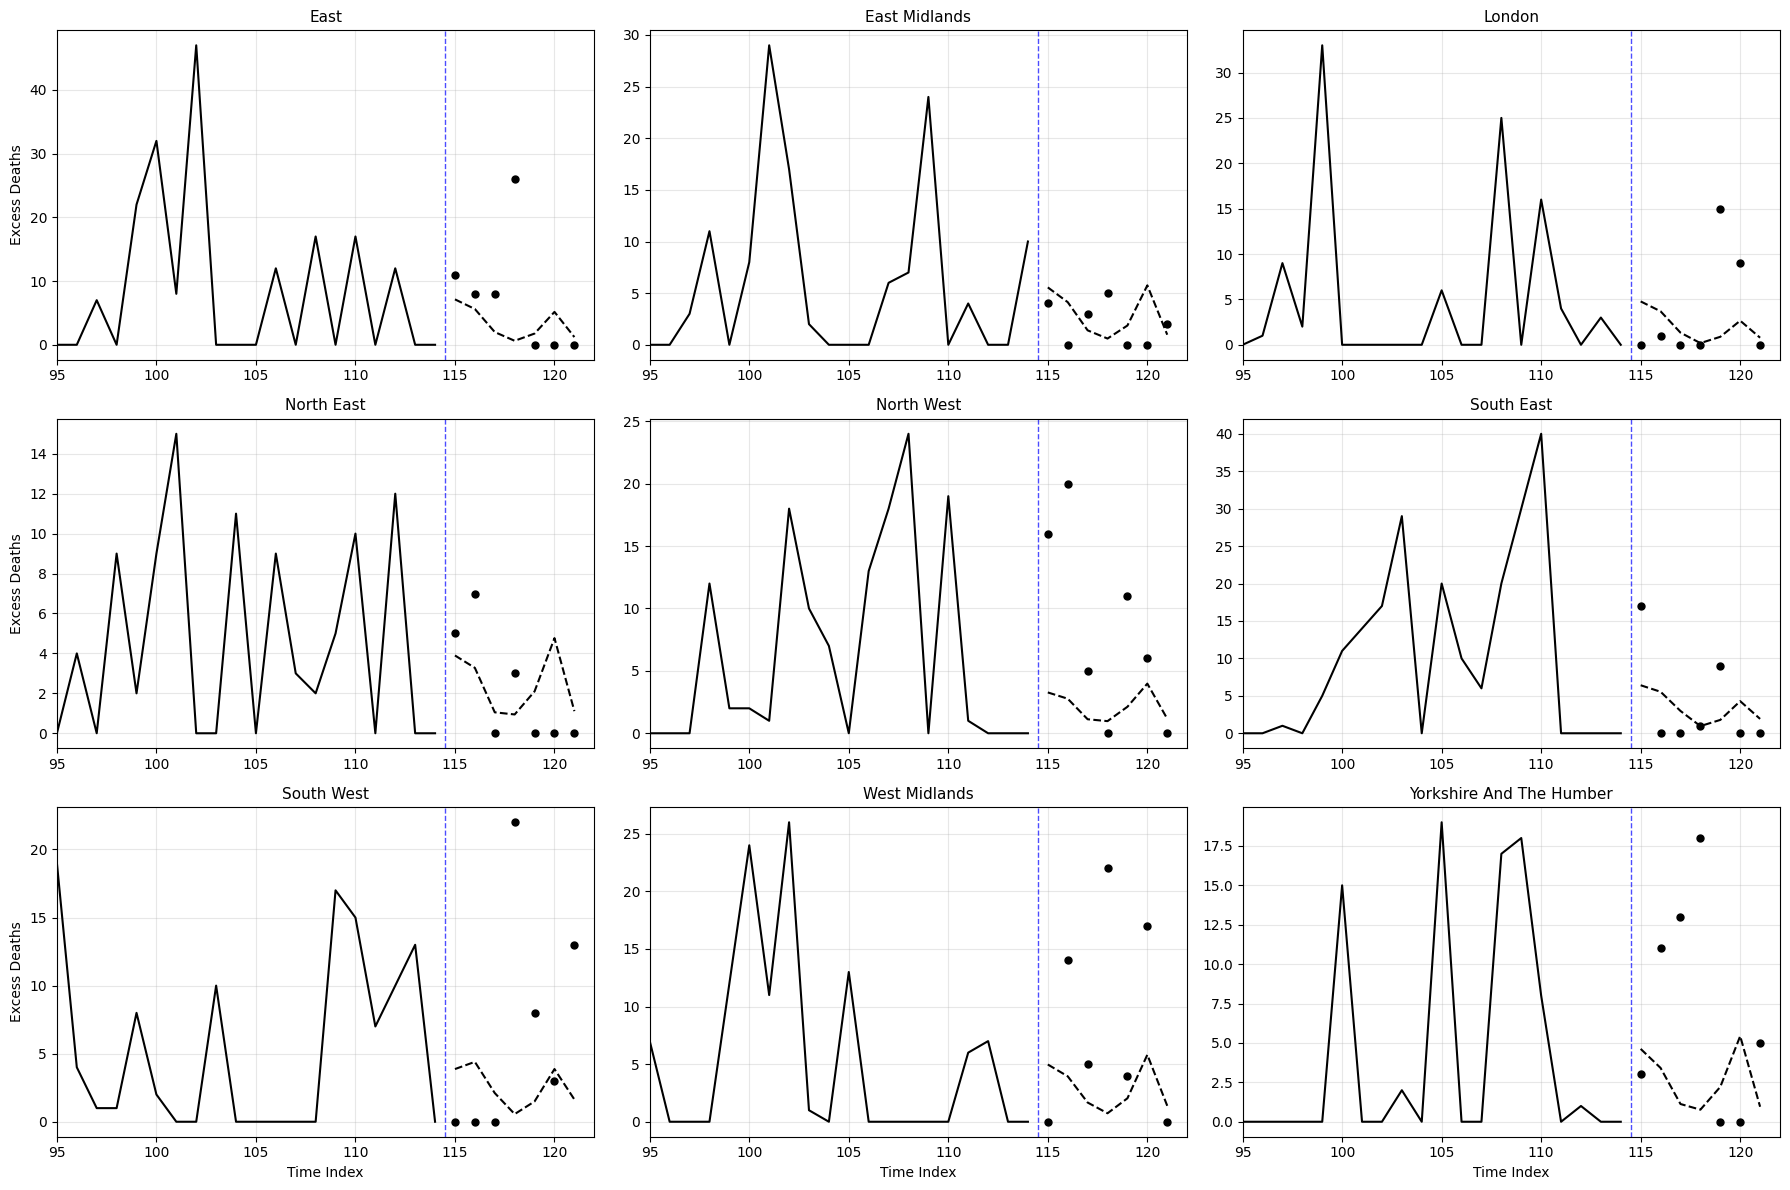


6. Plotting temperature...
Saved: rolling_forecast_temperature.png


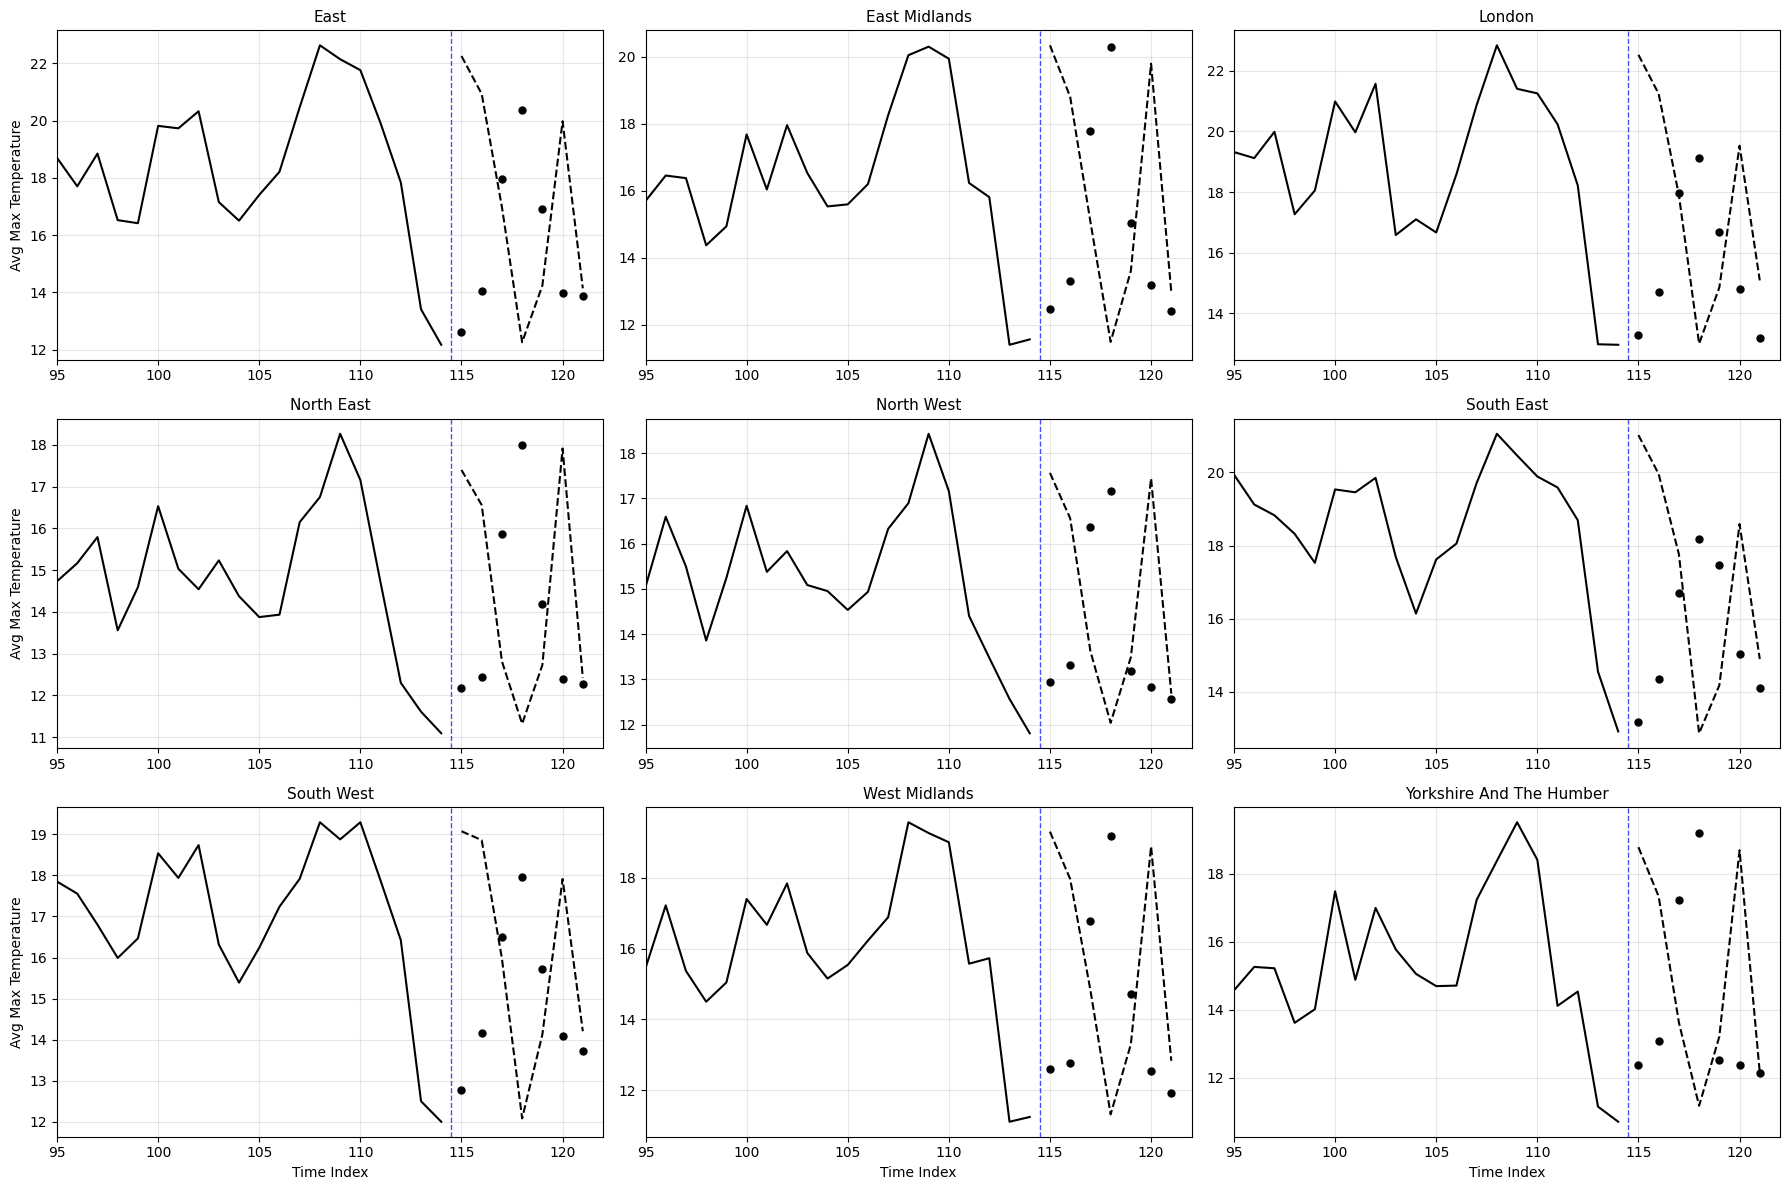


ANALYSIS COMPLETE!


In [15]:
print("="*80)
print("MULTITASK GP ROLLING FORECAST ANALYSIS")
print("="*80)

# Rolling forecast
print("\n3. Running rolling forecast...")
results = rolling_forecast_mogp(
    df, meta, SpatiotemporalMultitaskGP,
    gpytorch.likelihoods.MultitaskGaussianLikelihood,
    rolling_start_time=114, max_time=121,
    num_regions=meta['R'], num_months=meta['M'],
    train_params={'lr': 0.1, 'num_iter': 150},
    log_transform_deaths=True, verbose=True
)

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)


4. Forecast metrics:
   step  MAE_deaths  MAPE_deaths  RMSPE_deaths  MAE_temp  MAPE_temp  \
0   115    1.998421     0.288864      2.336082  7.095029   0.557277   
1   116    2.542613     0.358619      2.989565  5.114964   0.375249   
2   117    4.879730     0.737385      5.100419  1.847870   0.109798   
3   118    5.816668     0.887381      6.012149  6.877020   0.363172   
4   119    4.716136     0.708960      4.967723  1.630288   0.103267   
5   120    1.886198     0.252923      2.556538  5.280791   0.397895   
6   121    5.286591     0.800961      5.493551  0.575270   0.044184   

   RMSPE_temp  
0    7.273091  
1    5.232429  
2    2.187739  
3    6.994730  
4    1.840705  
5    5.389363  
6    0.793793  

   Saved: rolling_forecast_metrics.csv

5. Plotting excess deaths...
Saved: rolling_forecast_deaths.png


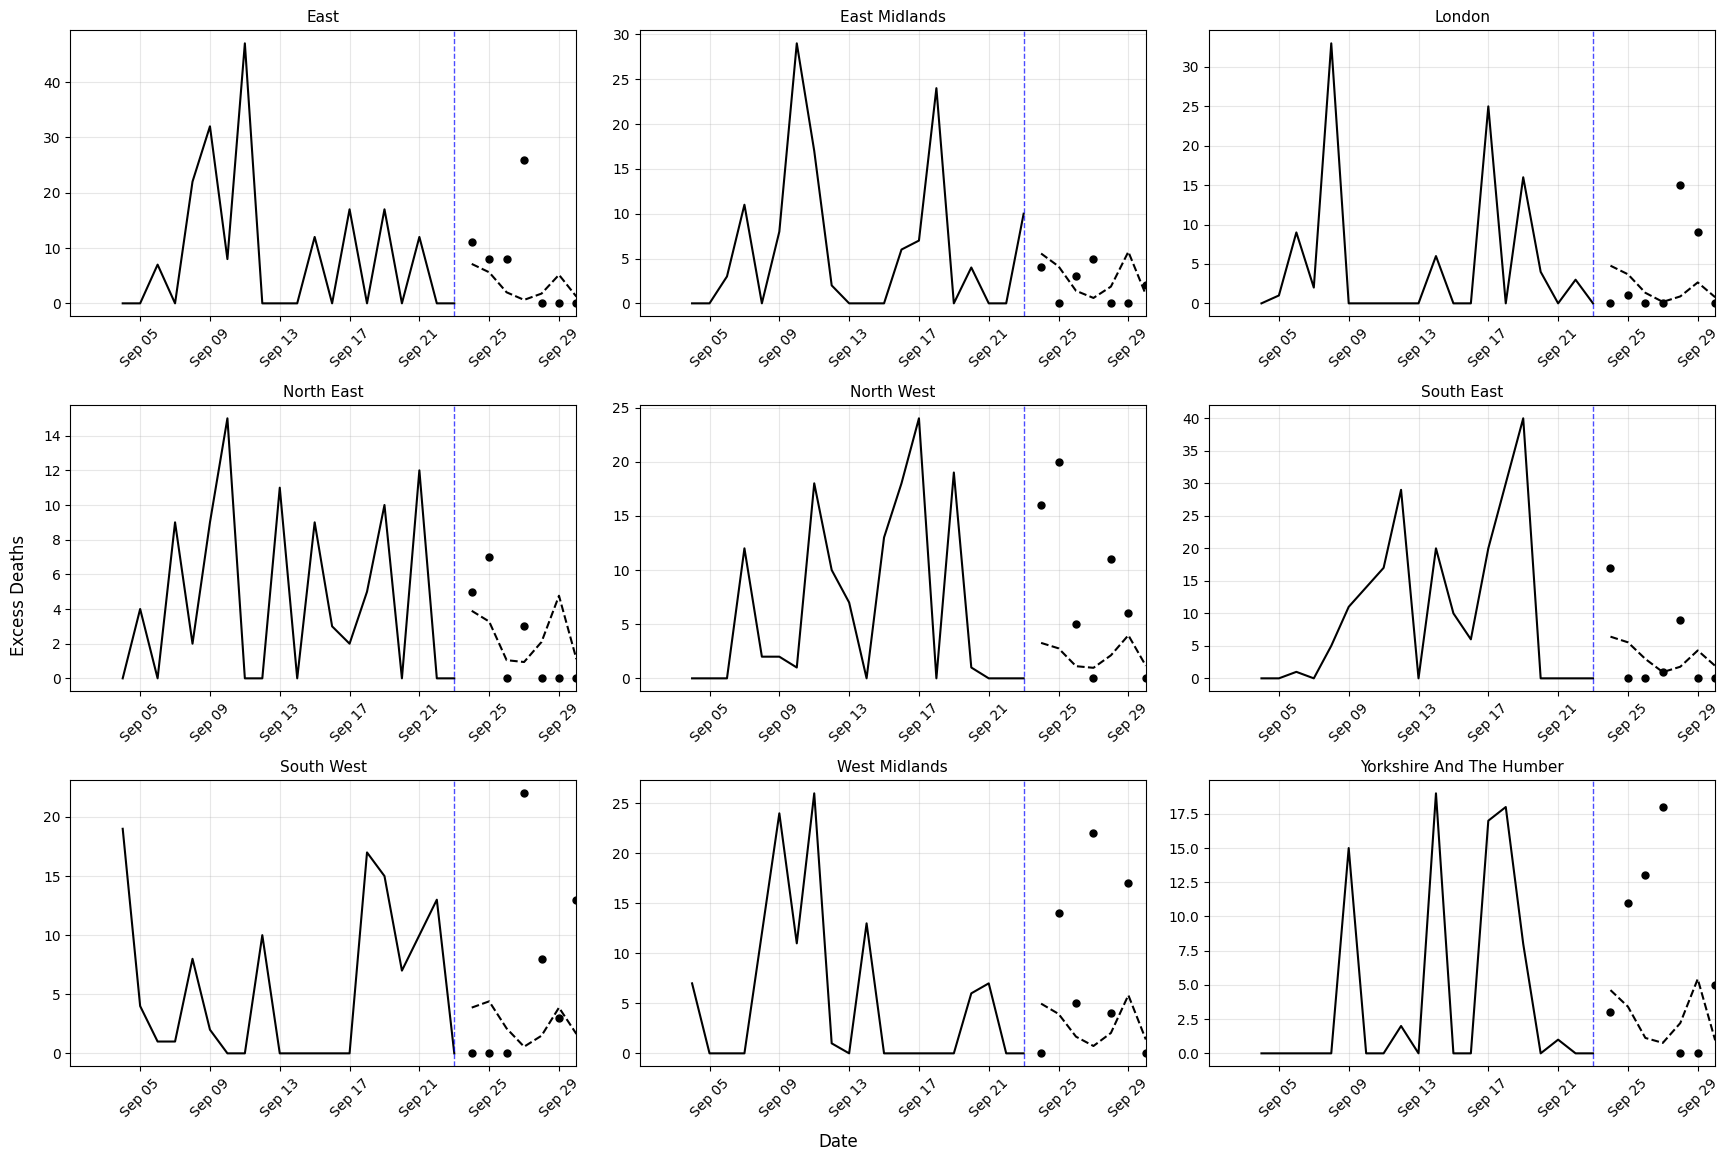


6. Plotting temperature...
Saved: rolling_forecast_temperature.png


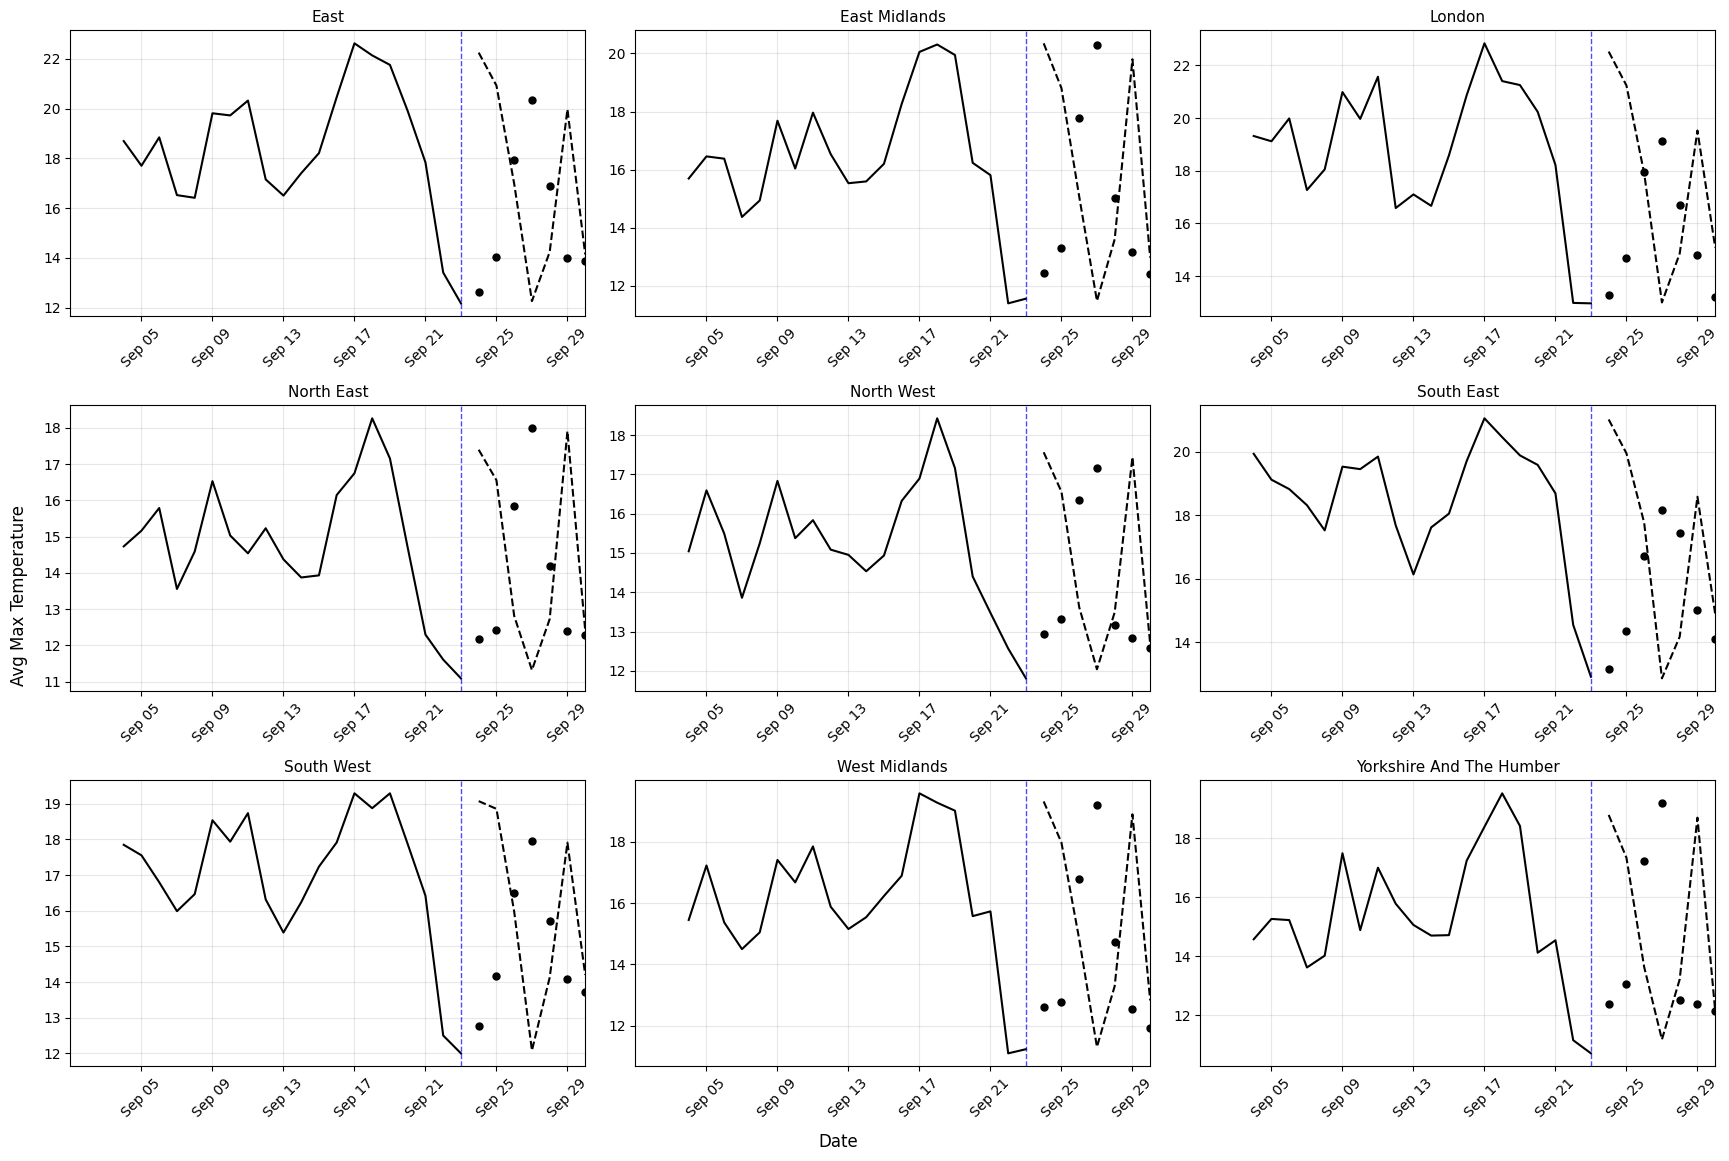

In [56]:
# Display metrics
print("\n4. Forecast metrics:")
print(results['summary_metrics'])

# Save metrics
results['summary_metrics'].to_csv('rolling_forecast_metrics.csv', index=False)
print("\n   Saved: rolling_forecast_metrics.csv")

# Plot deaths
print("\n5. Plotting excess deaths...")
plot_and_save_rolling_forecast(
    results, df, meta, modality=0,
    save_path='rolling_forecast_deaths.png'
)

# Plot temperature  
print("\n6. Plotting temperature...")
plot_and_save_rolling_forecast(
    results, df, meta, modality=1,
    save_path='rolling_forecast_temperature.png'
)